# Pent-up Frustration 2
The puzzle is available at https://www.janestreet.com/puzzles/pent-up-frustration-2-index/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [ ]:
eps = 1e-6

class Pentagon:
    def __init__(self, X0=0.0, Y0=0.0, up=90.0, side=1.0):
        self.X0, self.Y0 = X0, Y0
        self.up = up
        self.a = side
        self.vertices = self.get_vertices()
        self.is_leaf = True

    def get_relative_point(self, side, theta):
        theta = np.deg2rad(theta)
        return self.X0 + side*np.cos(theta), self.Y0 + side*np.sin(theta)

    def get_vertices(self):
        vertices = []
        l = 0.5 * self.a / np.cos(np.deg2rad(54.0))
        for i in range(5):
            X, Y = self.get_relative_point(l, self.up + 72*i)
            vertices.append([X,Y])
        return vertices

    def get_line_number(self, x, y, x1, y1, x2, y2):
        return (y-y1)*(x2-x1) - (y2-y1)*(x-x1)

    def is_point_inside(self, x, y):
        for i in range(4,-1,-1):
            l0 = self.get_line_number(self.X0, self.Y0, self.vertices[i][0], self.vertices[i][1], self.vertices[i-1][0], self.vertices[i-1][1])
            lp = self.get_line_number(x, y, self.vertices[i][0], self.vertices[i][1], self.vertices[i-1][0], self.vertices[i-1][1])
            if (abs(lp) < self.a*eps):
                return False
            if (l0 * lp < 0):
                return False
        return True

    def euclidean_distance(self, x1, y1, x2, y2):
        return ((x1-x2)**2 + (y1-y2)**2)**0.5

    def crosses(self, other):
        # Check if centers are minimum distance apart
        ccmin = self.a * np.tan(np.deg2rad(54.0))
        cc = self.euclidean_distance(self.X0, self.Y0, other.X0, other.Y0)
        if (cc < ccmin):
            return True
        # Check if any of the vertex is inside this pentagon
        for i in range(5):
            if (self.is_point_inside(other.vertices[i][0], other.vertices[i][1])):
                return True
        return False

    def is_crossing(self, pentagons):
        for p in pentagons:
            if self.crosses(p):
                return True
        return False

    def get_adjacent_pentagons(self):
        P = []
        ccmin = self.a * np.tan(np.deg2rad(54.0))
        for i in range(5):
            X, Y = self.get_relative_point(ccmin, self.up + 72*i + 36)
            P.append(Pentagon(X, Y, self.up + 72*i + 36))
        return P

    def draw(self, color='b', center=True, edges=True):
        if center:
            _ = plt.plot(self.X0, self.Y0, color+'*')
        for i in range(4,-1,-1):
            if edges:
                _ = plt.plot([self.vertices[i][0], self.vertices[i-1][0]], [self.vertices[i][1], self.vertices[i-1][1]], color)

In [ ]:
def reflected(arrangement):
    new_arrangement = []
    for pentagon in arrangement:
        new_arrangement.append(Pentagon(X0=-pentagon.X0, Y0=pentagon.Y0, up=180-pentagon.up, side=pentagon.a))
    return new_arrangement

def moved(arrangement, X=0.0, Y=0.0):
    new_arrangement = []
    for pentagon in arrangement:
        new_arrangement.append(Pentagon(X0=pentagon.X0+X, Y0=pentagon.Y0+Y, up=pentagon.up, side=pentagon.a))
    return new_arrangement

def rotated(arrangement, angle=0.0):
    new_arrangement = []
    theta = np.deg2rad(angle)
    for pentagon in arrangement:
        X = pentagon.X0 * np.cos(theta) - pentagon.Y0 * np.sin(theta)
        Y = pentagon.X0 * np.sin(theta) + pentagon.Y0 * np.cos(theta)
        new_arrangement.append(Pentagon(X0=X, Y0=Y, up=pentagon.up+angle, side=pentagon.a))
    return new_arrangement

def transformed(arrangement, X0=0.0, Y0=0.0, angle=0.0, reflect=False):
    new_arrangement = rotated(moved(arrangement, X0, Y0), angle)
    if reflect: new_arrangement = reflected(new_arrangement)
    return new_arrangement

def compare(arr1, arr2):
    def equals(arr1, arr2):
        c1 = [(round(pentagon.X0,6),round(pentagon.Y0,6)) for pentagon in arr1]
        c2 = [(round(pentagon.X0,6),round(pentagon.Y0,6)) for pentagon in arr2]
        return set(c1) == set(c2)

    for p in arr2:
        if p.is_leaf:
            transformed_arr = transformed(arr2, -p.X0, -p.Y0, 90-p.up, False)
            if equals(arr1, transformed_arr):
                return True
            transformed_arr = reflected(transformed_arr)
            if equals(arr1, transformed_arr):
                return True
    return False

In [ ]:
def next_arrangement(curr_idx, arrangements_function, arrangements, current_arrangement, n, N):
    is_leaf = current_arrangement[curr_idx].is_leaf
    current_arrangement[curr_idx].is_leaf = False
    possible_next_pentagons = current_arrangement[curr_idx].get_adjacent_pentagons()
    for i in [1, 0, 3, 4]:
        if n==2 and i>1:
            continue
        next_pentagon = possible_next_pentagons[i]
        if not next_pentagon.is_crossing(current_arrangement):
            current_arrangement.append(next_pentagon)
            arrangements_function(arrangements, current_arrangement, n+1, N)
            current_arrangement.pop(-1)
    current_arrangement[curr_idx].is_leaf = is_leaf

# Back-tracking Algorithm
def all_arrangements(arrangements, current_arrangement, n, N):
    if n==N:
        arrangements.append(copy.deepcopy(current_arrangement))
        return
    for pent_idx in range(1, len(current_arrangement)):
        next_arrangement(pent_idx, all_arrangements, arrangements, current_arrangement, n, N)
    return

def get_unique_arrangements(arrangements):
    unique = []
    N = len(arrangements)
    for i in range(N):
        j = len(unique)-1
        while (j>=0):
            if compare(arrangements[i], unique[j]): break
            j -= 1
        if j<0: unique.append(arrangements[i])
    return unique

# Recursive-building Algorithm
def unique_arrangements(N):
    n, arrangements = 2, [[Pentagon(), Pentagon().get_adjacent_pentagons()[2]]]
    while (n<N):
        next_arrangements = []
        for arr in arrangements:
            for pi in range(1, len(arr)):
                possible_next_pentagons = arr[pi].get_adjacent_pentagons()
                is_leaf = arr[pi].is_leaf
                arr[pi].is_leaf = False
                for i in [1, 0, 3, 4]:
                    if n==2 and i>1: continue
                    next_pentagon = possible_next_pentagons[i]
                    if not next_pentagon.is_crossing(arr):
                        arr.append(next_pentagon)
                        next_arrangements.append(copy.deepcopy(arr))
                        arr.pop(-1)
                arr[pi].is_leaf = is_leaf
        print('\nNumber of arrangements for n=' + str(n+1) + ' is ' + str(len(next_arrangements)))
        arrangements = get_unique_arrangements(next_arrangements)
        print('Number of unique arrangements for n=' + str(n+1) + ' is ' + str(len(arrangements)))
        n += 1
    return arrangements

In [ ]:
N = 5
arrangements = []
#all_arrangements(arrangements, [Pentagon(), Pentagon().get_adjacent_pentagons()[2]], 2, N)
arrangements = unique_arrangements(N)
print('\nNumber of arrangements for n=' + str(N) + ' is ' + str(len(arrangements)))


Number of arrangements for n=3 is 2
Number of unique arrangements for n=3 is 2

Number of arrangements for n=4 is 9
Number of unique arrangements for n=4 is 6

Number of arrangements for n=5 is 40
Number of unique arrangements for n=5 is 19

Number of arrangements for n=5 is 19


{(0.0, 0.0), (2.118034, 0.16246), (-0.5, -2.915224), (-0.0, -1.376382), (0.809017, -2.489898), (1.309017, -0.951057)}
[True, False, False, False, True, True]


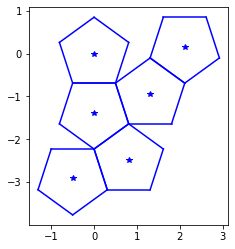

In [ ]:
def draw_arrangement(arrangement):
    c, leaf = set(), []
    for pi in range(len(arrangement)):
        arrangement[pi].draw()
        c.add((round(arrangement[pi].X0,6),round(arrangement[pi].Y0,6)))
        leaf.append(arrangement[pi].is_leaf)
    print(c)
    print(leaf)
    _ = plt.axis('scaled')

i = 6
arrangement = arrangements[i]
draw_arrangement(arrangement)

In [ ]:
len(get_unique_arrangements(arrangements))

22

Maximum prob. 0.7474747474747475 occurs at (a,b)=(1, 0)


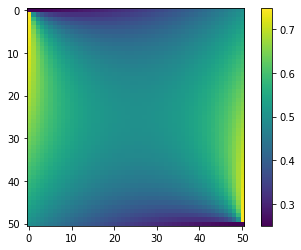

In [ ]:
N, P = 50, []
maxA, maxB, maxP = -1, -1, 0
for a in range(N+1):
    p = []
    for b in range(N+1):
        if (a==0 and b==0) or (a+b==2*N):
            prob = 0.5 * max(a,N-a) / (2*N)
        else:
            prob = 0.5*(a/(a+b)) + 0.5*((N-a)/(2*N-a-b))
        p.append(prob)
        if (maxP < prob):
            maxP = prob
            maxA, maxB = a, b
    P.append(p)
print("Maximum prob. " + str(maxP) + " occurs at (a,b)=" + str((maxA,maxB)))

plt.imshow(np.array(P), interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

In [ ]:
def get_prob(ranks, i, j):
    if (i==j):
        return 1
    return ranks[i] / (ranks[i] + ranks[j])

def get_leaves(i, k, n):
    jmin, jmax = 0, 2**n-1
    while (n>k):
        mid = (jmin + jmax)//2
        if (i > mid):
            jmin = mid+1
        else:
            jmax = mid
        n -= 1
    mid = (jmin + jmax)//2
    if (i > mid):
        jmax = mid
    else:
        jmin = mid+1
    return [j for j in range(jmin, jmax+1)]

def get_winning_prob(ranks):
    N = len(ranks)
    n = int(np.log2(N))
    QMatrix = np.array([[get_prob(ranks, i, j) for j in range(N)] for i in range(N)])

    P = [[1]*N]
    for k in range(1,n+1):
        Pk = []
        for i in range(N):
            pik, J = 0, get_leaves(i, k, n)
            for j in J:
                pik += QMatrix[i][j] * P[k-1][j]
            Pk.append(P[k-1][i] * pik)
        P.append(Pk)
    return QMatrix, np.array(P)

def get_winning_prob_fast(ranks):
    N = len(ranks)
    n = int(np.log2(N))
    QMatrix = np.array([[get_prob(ranks, i, j) for j in range(N)] for i in range(N)])

    P, mu = [[1]*N], [ranks]
    for k in range(1,n+1):
        Pk, muk = [], []
        m = 0
        for i in range(N):
            j = get_leaves(i, 1, n-k+1)[0]
            pik = P[k-1][i] * (ranks[i] / (ranks[i] + mu[k-1][j]))
            Pk.append(pik)
        for m in range(0, len(mu[k-1]), 2):
            muk.append((2**k)*mu[k-1][m]*mu[k-1][m+1] / (mu[k-1][m] + mu[k-1][m+1]))
        P.append((np.array(Pk)/sum(Pk)).tolist())
        mu.append(muk)
    return QMatrix, np.array(P)

In [ ]:
ranks = [1, 3, 1, 2, 1, 3, 2, 8]
QMatrix, P = get_winning_prob(ranks)
#QMatrix, Pfast = get_winning_prob_fast(ranks)

print(np.round(P, 4)*100)
#print(Pfast[-1])

[[100.   100.   100.   100.   100.   100.   100.   100.  ]
 [ 25.    75.    33.33  66.67  25.    75.    20.    80.  ]
 [  9.72  48.75  10.42  31.11   3.89  25.36   9.33  61.41]
 [  1.77  18.5    1.9    9.24   1.27  14.75   4.52  48.05]]
